# Identifying safe loans with decision trees
The [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to [default](https://en.wikipedia.org/wiki/Default_%28finance%29).

In this notebook you will use data from the LendingClub to predict whether a loan will be paid off in full or the loan will be [charged off](https://en.wikipedia.org/wiki/Charge-off) and possibly go into default. In this assignment you will:

* Data cleaning: imbalanced data, one-hot encoding
* Train a decision-tree on the LendingClub dataset.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Train a complex tree model and compare it to simple tree model.
* Visualize decision tree, plot confusion matrix

In [75]:
import numpy as np
import pandas as pd
import json
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline 

# Load LendingClub dataset

In [24]:
loans = pd.read_csv('data_files/lending-club-data.csv')
loans.head(2)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (19,47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,sub_grade_num,delinq_2yrs_zero,pub_rec_zero,collections_12_mths_zero,short_emp,payment_inc_ratio,final_d,last_delinq_none,last_record_none,last_major_derog_none
0,1077501,1296599,5000,5000,4975,36 months,10.65,162.87,B,B2,...,0.4,1.0,1.0,1.0,0,8.1435,20141201T000000,1,1,1
1,1077430,1314167,2500,2500,2500,60 months,15.27,59.83,C,C4,...,0.8,1.0,1.0,1.0,1,2.3932,20161201T000000,1,1,1


In [25]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

## Exploring the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [26]:
loans['safe_loans']=loans['bad_loans'].apply(lambda x: +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis=1)

In [27]:
loans['safe_loans'].value_counts()

print (len(loans[loans['safe_loans']==+1]) *1.0/ len(loans['safe_loans']))
print (len(loans[loans['safe_loans']==-1]) *1.0/ len(loans['safe_loans']))

0.8111853319957262
0.18881466800427382


* Around 81% safe loans
* Around 19% risky loans

It looks like most of these loans are safe loans (thankfully). But this does make our problem of identifying risky loans challenging.

## Features for the classification algorithm

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

In [28]:
features = ['grade',                     # grade of the loan
            'sub_grade',                 # sub-grade of the loan
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'term',                      # the term of the loan
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee']

target = ['safe_loans']

loans = loans[features+target]

What remains now is a **subset of features** and the **target** that we will use for the rest of this notebook. 

## Subample data to balance classes

As we explored above, our data is disproportionally full of safe loans.  Let's create two datasets: one with just the safe loans (`safe_loans_raw`) and one with just the risky loans (`risky_loans_raw`).

Purpose: Deal with imbalanced data by subsampling the overly represented class to get a more balanced dataset

In [29]:
#safe_loans_raw = loans[loans[target] == +1]
#risky_loans_raw = loans[loans[target] == -1]
#print("Number of safe loans  : %s" % len(safe_loans_raw))
#print("Number of risky loans : %s" % len(risky_loans_raw))

# Since there are fewer risky loans than safe loans, find the ratio of the sizes
# and use that percentage to undersample the safe loans.
#percentage = len(risky_loans_raw)/float(len(safe_loans_raw))

#risky_loans = risky_loans_raw
#safe_loans = safe_loans_raw.sample(percentage, seed=1)

# Append the risky_loans with the downsampled version of safe_loans
#loans_data = risky_loans.append(safe_loans)

##  One-hot encoding
For scikit-learn's decision tree implementation, it requires numerical values for it's data matrix. This means you will have to turn categorical variables into binary features via one-hot encoding. 

In [30]:
categorical_variables = []
for feat_name, feat_type in zip(loans.columns, loans.dtypes):             # identify categorical columns
    if feat_type == object:
        categorical_variables.append(feat_name)

In [31]:
categorical_variables

['grade', 'sub_grade', 'home_ownership', 'purpose', 'term']

In [32]:
for feature in categorical_variables:
    
    loans_one_hot_encoded = pd.get_dummies(loans[feature],prefix=feature) # generate dummies
    
    loans = loans.drop(feature, axis=1)
    for col in loans_one_hot_encoded.columns:
        loans[col] = loans_one_hot_encoded[col]                           # append dummies to loans data

In [33]:
print(loans.columns)
loans.head(2)

Index(['short_emp', 'emp_length_num', 'dti', 'last_delinq_none',
       'last_major_derog_none', 'revol_util', 'total_rec_late_fee',
       'safe_loans', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F', 'grade_G', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
       'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2',
       'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1',
       'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5',
       'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4',
       'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3',
       'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2',
       'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1',
       'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_car', 'purpose_credit_card'

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,0,11,27.65,1,1,83.7,0.0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1,1,1.00,1,1,9.4,0.0,-1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [34]:
loans.dtypes

short_emp                   int64
emp_length_num              int64
dti                       float64
last_delinq_none            int64
last_major_derog_none       int64
                           ...   
purpose_small_business      uint8
purpose_vacation            uint8
purpose_wedding             uint8
term_ 36 months             uint8
term_ 60 months             uint8
Length: 68, dtype: object

## Train-validation split

In [35]:
with open('data_files/module-5-assignment-1-train-idx.json') as train_data_file:    
    train_idx  = json.load(train_data_file)
with open('data_files/module-5-assignment-1-validation-idx.json') as validation_data_file:    
    validation_idx = json.load(validation_data_file)
    
print(train_idx[:3])
print(validation_idx[:3])

train_data=loans.iloc[train_idx]
validation_data = loans.iloc[validation_idx]

[1, 6, 7]
[24, 41, 60]


# Build a decision tree classifier

Now, let's use the built-in scikit learn decision tree learner [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to create a loan prediction model on the training data. To do this, you will need to import sklearn, sklearn.tree, and numpy.

In [40]:
train_Y = train_data['safe_loans'].to_numpy()
train_X = train_data.drop('safe_loans', axis=1).to_numpy()

print (train_Y.shape, type(train_Y))
print (train_X.shape, type(train_X))

(37224,) <class 'numpy.ndarray'>
(37224, 67) <class 'numpy.ndarray'>


In [41]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(max_depth=6)
decision_tree_model = decision_tree_model.fit(train_X, train_Y)

## Building a smaller tree
Typically the max depth of the tree is capped at 6. However, such a tree can be hard to visualize graphically, and moreover, it may overfit...  Here, we instead learn a smaller model with **max depth of 2** to gain some intuition and to understand the learned tree more.

In [42]:
small_model = DecisionTreeClassifier(max_depth=2)
small_model = small_model.fit(train_X, train_Y)

## Visualize the decision tree

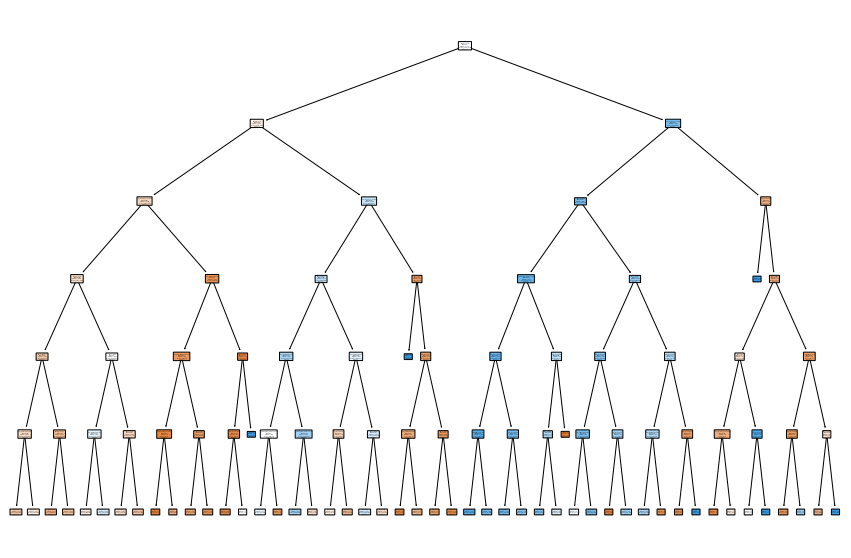

In [52]:
fig = plt.figure(figsize=(15,10)) #The plot_tree returns annotations for the plot, 
                                  #to not show them in the notebook I assigned returned value to _.

_ = plot_tree(decision_tree_model,
          filled = True,
          rounded = True,
          class_names = ['+1','-1'],
          feature_names = train_data.drop('safe_loans', axis=1).columns)
plt.savefig("decistion_tree_big.svg")

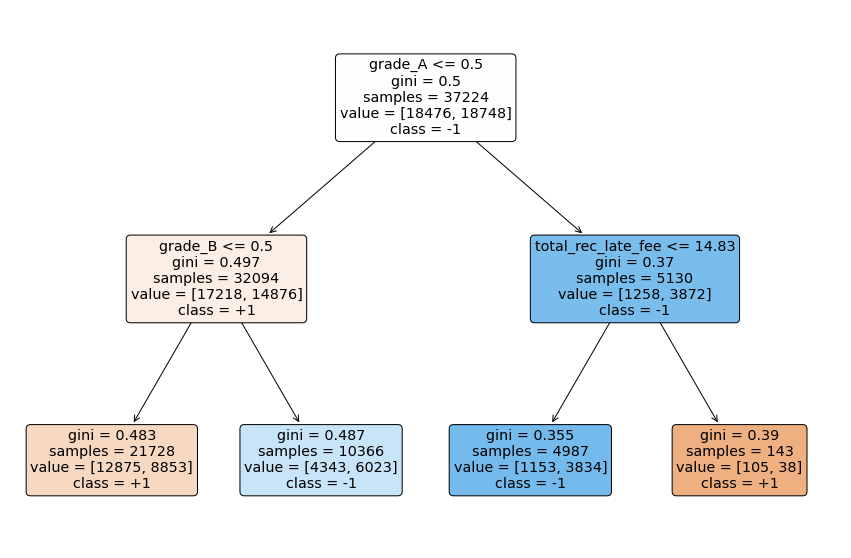

In [51]:
fig = plt.figure(figsize=(15,10)) #The plot_tree returns annotations for the plot, 
                                  #to not show them in the notebook I assigned returned value to _.

_ = plot_tree(small_model,
          filled = True,
          rounded = True,
          class_names = ['+1','-1'],
          feature_names = train_data.drop('safe_loans', axis=1).columns)
plt.savefig("decistion_tree.svg")

# Making predictions

Let's consider two positive and two negative examples **from the validation set** and see what the model predicts. We will do the following:
* Predict whether or not a loan is safe.
* Predict the probability that a loan is safe.

In [53]:
validation_safe_loans = validation_data[validation_data['safe_loans'] == 1]
validation_risky_loans = validation_data[validation_data['safe_loans'] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
19,0,11,11.18,1,1,82.4,0.0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
79,0,10,16.85,1,1,96.4,0.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
24,0,3,13.97,0,1,59.5,0.0,-1,0,0,...,0,0,0,0,1,0,0,0,0,1
41,0,11,16.33,1,1,62.1,0.0,-1,1,0,...,0,0,0,0,0,0,0,0,1,0


## Explore label predictions
Now, we will use our model  to predict whether or not a loan is likely to default. For each row in the **sample_validation_data**, use the **decision_tree_model** to predict whether or not the loan is classified as a **safe loan**. 

**Hint:** Be sure to use the `.predict()` method.

In [54]:
sample_validation_data_X = sample_validation_data.drop('safe_loans', axis=1)
sample_validation_data_Y = sample_validation_data['safe_loans']
print(sample_validation_data_Y)
decision_tree_model.predict(sample_validation_data_X)

19    1
79    1
24   -1
41   -1
Name: safe_loans, dtype: int64


array([ 1, -1, -1,  1])

## Explore probability predictions

For each row in the **sample_validation_data**, what is the probability (according **decision_tree_model**) of a loan being classified as **safe**? 


**Hint:** Use `predict_proba()` to make **probability** predictions using **decision_tree_model** on `sample_validation_data`:

In [55]:
decision_tree_model.predict_proba(sample_validation_data_X)

array([[0.34156543, 0.65843457],
       [0.53630646, 0.46369354],
       [0.64750958, 0.35249042],
       [0.20789474, 0.79210526]])

In [56]:
# use small_model to predict
small_model.predict(sample_validation_data_X)

array([ 1, -1, -1,  1])

In [57]:
small_model.predict_proba(sample_validation_data_X)

array([[0.41896585, 0.58103415],
       [0.59255339, 0.40744661],
       [0.59255339, 0.40744661],
       [0.23120112, 0.76879888]])

# Evaluating accuracy of the decision tree models

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Let us start by evaluating the accuracy of the `small_model` and `decision_tree_model` on the training data

In [59]:
d=small_model.predict(train_X)
print(d[:3])

[-1 -1  1]


In [60]:
print(train_Y[:3])

[-1 -1 -1]


In [61]:
np.sum(d==train_Y)

22837

In [64]:
accuracy=np.sum(d==train_Y)/len(train_Y)
print('The accuracy of prediction on training data using small_model is:',accuracy)

The accuracy of prediction on training data using small_model is: 0.6135020416935311


In [65]:
accuracy=np.sum(decision_tree_model.predict(train_X)==train_Y)/len(train_Y)
print('The accracy of prediction on training data using decision_tree_model is:',accuracy)

The accracy of prediction on training data using complex model is: 0.6405276165914464


Evaluating the accuracy of the `small_model` and `decision_tree_model` on the validation data

In [66]:
validation_Y = validation_data['safe_loans']
validation_X = validation_data.drop('safe_loans', axis=1)
print (validation_Y.shape)
print (validation_X.shape)

(9284,)
(9284, 67)


In [68]:
accuracy=np.sum (small_model.predict(validation_X) == validation_Y)/len(validation_Y)
print('The accuracy of prediction on validation data using small_model is:',accuracy)

The accuracy of prediction on validation data using small_model is: 0.6193451098664369


In [73]:
accuracy=np.sum (decision_tree_model.predict(validation_X) == validation_Y)/len(validation_Y)
print('The accuracy of prediction on validation data using decision_tree_model is:',accuracy)

The accuracy of prediction on validation data using decision_tree_model is: 0.6361482119775959


### Evaluate accuracy of a complex decision tree model: max_depth=10

In [70]:
big_model = DecisionTreeClassifier(max_depth=10)
big_model = big_model.fit(train_X, train_Y)

In [71]:
accuracy=np.sum (big_model.predict(train_X) == train_Y)/len(train_Y)
print('The accuracy of prediction on training data using big_model is:',accuracy)

The accuracy of prediction on training data using big_model is: 0.6637384483129164


In [72]:
accuracy=np.sum (big_model.predict(validation_X) == validation_Y)/len(validation_Y)
print('The accuracy of prediction on validation data using big_model is:',accuracy)

The accuracy of prediction on validation data using big_model is: 0.6274235243429557


### Quantifying the cost of mistakes of decision_tree_model on validation set

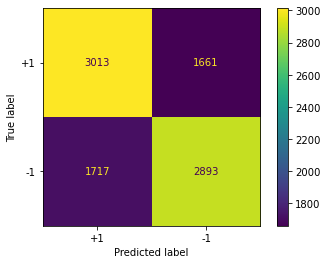

In [76]:
plot_confusion_matrix(decision_tree_model, validation_X, validation_Y, display_labels =['+1','-1'])

In [77]:
predictions = decision_tree_model.predict(validation_X)

In [78]:
false_positives = np.sum ((predictions==1) * (validation_Y==-1))
print('The number of false positives in validation data is:',false_positives)
false_negatives = np.sum ((predictions==-1) * (validation_Y==1))
print('The number of false negatives in validation data is:',false_negatives)

The number of false positives in validation data is: 1661
The number of false negatives in validation data is: 1717


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


Let us assume that each mistake costs money:
* Assume a cost of \$10,000 per false negative.
* Assume a cost of \$20,000 per false positive.

What is the total cost of mistakes made by `decision_tree_model` on `validation_data`?

In [80]:
print ('Total cost is:', 10000 * false_negatives + 20000 * false_positives)

Total cost is: 50390000
